# Import Libraries

In [1]:
from darts import TimeSeries
#from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
#from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
#from darts.dataprocessing.transformers import Scaler,MissingValuesFiller
#from darts.metrics import mape, r2_score, rmse

In [2]:
import pandas as pd

# Import dataset

In [3]:
train=pd.read_csv('train.csv')
train.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


# Get Info, Clean and Fill missing values present in training set

In [4]:
train=train.drop(train[['row_id']],axis=1)
train.head()

,datetime,energy
0,2008-03-01 00:00:00,1259.985563
1,2008-03-01 01:00:00,1095.541500
2,2008-03-01 02:00:00,1056.247500
3,2008-03-01 03:00:00,1034.742000
4,2008-03-01 04:00:00,1026.334500


In [5]:
train.isnull().sum()

datetime       0
energy      1900
dtype: int64

In [6]:
train.dtypes

datetime     object
energy      float64
dtype: object

In [7]:
train.shape

(94992, 2)

In [8]:
train = train.set_index('datetime')
train.head()

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500


<AxesSubplot:xlabel='datetime'>

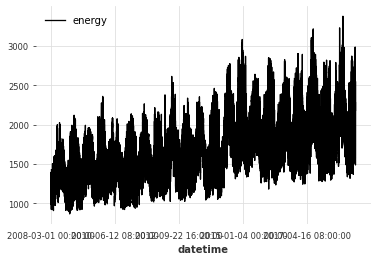

In [9]:
train.plot()

In [10]:
train=train.interpolate()

In [11]:
train.isnull().sum()

energy    0
dtype: int64

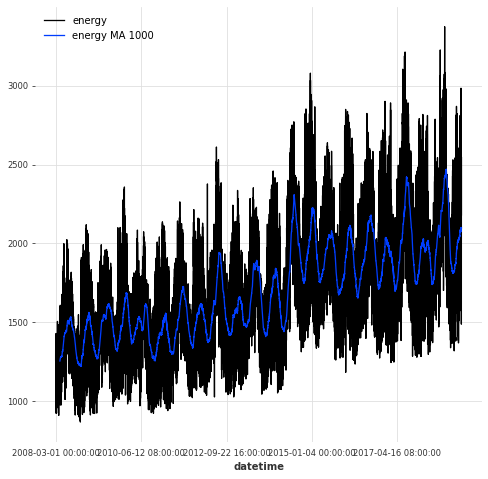

In [16]:
#import numpy as np
#train=np.log(train)
import matplotlib.pyplot as plt
r90 = train.rolling(window=1000).mean() #<---- Moving Average
train.join(r90.add_suffix(' MA 1000')).plot(figsize=(8,8))
plt.show()

In [17]:
train=train.join(r90.add_suffix(' MA 1000'))

In [18]:
train=train.reset_index()

In [21]:
train.head()

,datetime,energy,energy MA 1000
0,2008-03-01 00:00:00,1259.985563,NaN
1,2008-03-01 01:00:00,1095.541500,NaN
2,2008-03-01 02:00:00,1056.247500,NaN
3,2008-03-01 03:00:00,1034.742000,NaN
4,2008-03-01 04:00:00,1026.334500,NaN


In [22]:
train=train.drop(train[['energy']],axis=1)
train.head()

,datetime,energy MA 1000
0,2008-03-01 00:00:00,NaN
1,2008-03-01 01:00:00,NaN
2,2008-03-01 02:00:00,NaN
3,2008-03-01 03:00:00,NaN
4,2008-03-01 04:00:00,NaN


In [23]:
train=train.dropna()
train.head()

,datetime,energy MA 1000
999,2008-04-11 15:00:00,1253.727779
1000,2008-04-11 16:00:00,1253.895653
1001,2008-04-11 17:00:00,1254.243546
1002,2008-04-11 18:00:00,1254.692949
1003,2008-04-11 19:00:00,1255.191116


In [24]:
train.tail()

,datetime,energy MA 1000
94987,2018-12-31 19:00:00,2096.219002
94988,2018-12-31 20:00:00,2097.010122
94989,2018-12-31 21:00:00,2097.693895
94990,2018-12-31 22:00:00,2098.295555
94991,2018-12-31 23:00:00,2098.627553


In [26]:
train.shape

(93993, 2)

In [28]:
train.columns

Index(['datetime', 'energy MA 1000'], dtype='object')

# Convert data to darts timeseries dataframe and create Train and validation data sets and train the TCN model

In [29]:
from darts import TimeSeries
train = TimeSeries.from_dataframe(train, 'datetime', 'energy MA 1000')

In [30]:
train_energy, val_energy = train[:-26280],train[-26280:]

In [31]:
train_energy

<TimeSeries (DataArray) (datetime: 67713, component: 1, sample: 1)>
array([[[1253.72777912]],

       [[1253.89565256]],

       [[1254.24354606]],

       ...,

       [[2089.9053981 ]],

       [[2090.6645045 ]],

       [[2091.1911865 ]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 2008-04-11T15:00:00 ... 2016-01-01T2...
  * component  (component) object 'energy MA 1000'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [32]:
from darts.models import TCNModel

In [33]:
from torchmetrics import MeanAbsolutePercentageError

In [34]:
model_energy = TCNModel(input_chunk_length=8750, output_chunk_length=8749, kernel_size=5, num_filters=5, num_layers=15, dilation_base=2, weight_norm=False, dropout=0.5,torch_metrics=MeanAbsolutePercentageError())

In [35]:
model_energy.fit([train_energy,],val_series=[val_energy],epochs=5, verbose=True)

2022-11-19 13:26:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-19 13:26:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-19 13:26:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-19 13:26:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-19 13:26:24 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 3.7 K 
----------------------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.030     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022-11-19 18:44:02 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=5` reached.


# Forecast from model for submission

In [36]:
pred = model_energy.predict(n=26304,series=train)

Predicting: 1570it [00:00, ?it/s]

In [37]:
test=pd.read_csv('test.csv')

In [38]:
test.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


In [39]:
pred

<TimeSeries (DataArray) (datetime: 26304, component: 1, sample: 1)>
array([[[2085.37652798]],

       [[2085.25308474]],

       [[2084.96592111]],

       ...,

       [[2459.19999742]],

       [[2459.94928493]],

       [[2460.71471324]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 2019-01-01 ... 2021-12-31T23:00:00
  * component  (component) object 'energy MA 1000'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [40]:
pred.to_csv('pred1.csv',index=False)

In [41]:
pred1=pd.read_csv('pred1.csv')
pred1.head()

,energy MA 1000
0,2085.376528
1,2085.253085
2,2084.965921
3,2088.053936
4,2088.084088


In [42]:
#pred1 = np.exp(pred1)
pred1.rename(columns={'energy MA 1000': 'energy'},
          inplace=True, errors='raise')

In [43]:
new_pred=test.join(pred1)
new_pred

,row_id,datetime,energy
0,94993,2019-01-01 00:00:00,2085.376528
1,94994,2019-01-01 01:00:00,2085.253085
2,94995,2019-01-01 02:00:00,2084.965921
3,94996,2019-01-01 03:00:00,2088.053936
4,94997,2019-01-01 04:00:00,2088.084088
...,...,...,...
26299,121292,2021-12-31 19:00:00,2457.991033
26300,121293,2021-12-31 20:00:00,2458.538256
26301,121294,2021-12-31 21:00:00,2459.199997
26302,121295,2021-12-31 22:00:00,2459.949285


In [44]:
new_pred=new_pred.drop(new_pred[['datetime']],axis=1)

In [45]:
new_pred

,row_id,energy
0,94993,2085.376528
1,94994,2085.253085
2,94995,2084.965921
3,94996,2088.053936
4,94997,2088.084088
...,...,...
26299,121292,2457.991033
26300,121293,2458.538256
26301,121294,2459.199997
26302,121295,2459.949285


In [46]:
new_pred.to_csv('pred_mov_avg_1000.csv',index=False)